In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
import json
import time
import random
from fake_useragent import UserAgent

In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
def crawl_tiki_products(category_id=1789, num_pages=10):
    print(f"Đang crawl dữ liệu từ Tiki.vn (Category ID: {category_id})...")
    
    ua = UserAgent()
    products = []
    
    for page in range(1, num_pages + 1):
        try:
            # Tiki API endpoint
            url = f"https://tiki.vn/api/personalish/v1/blocks/listings?limit=40&category={category_id}&page={page}"
            
            headers = {
                'User-Agent': ua.random,
                'Accept': 'application/json, text/plain, */*',
                'Accept-Language': 'vi-VN,vi;q=0.9,en-US;q=0.8,en;q=0.7',
                'Referer': 'https://tiki.vn/',
                'x-guest-token': 'token'
            }
            
            response = requests.get(url, headers=headers, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                if 'data' in data:
                    for item in data['data']:
                        try:
                            product = {
                                'product_id': item.get('id', np.nan),
                                'name': item.get('name', 'Unknown'),
                                'price': item.get('price', 0),
                                'original_price': item.get('original_price', 0),
                                'discount': item.get('discount_rate', 0),
                                'rating': item.get('rating_average', 0),
                                'review_count': item.get('review_count', 0),
                                'sold_count': item.get('quantity_sold', {}).get('value', 0),
                                'brand': item.get('brand_name', 'Unknown'),
                                'category': category_id
                            }
                            products.append(product)
                        except Exception as e:
                            continue
                
                print(f"Đã crawl trang {page}/{num_pages} - Tổng: {len(products)} sản phẩm")
                time.sleep(random.uniform(1, 3))  # Tránh bị block
                
            else:
                print(f"Lỗi trang {page}: Status code {response.status_code}")
                
        except Exception as e:
            print(f"Lỗi trang {page}: {str(e)}")
            continue
    
    return pd.DataFrame(products)

def generate_customer_transactions(df_products, n_customers=500, n_transactions=5000):
    """
    Tạo dữ liệu giao dịch khách hàng từ danh sách sản phẩm thật
    """
    print("\nĐang tạo dữ liệu giao dịch khách hàng...")
    
    np.random.seed(42)
    transactions = []
    
    # Tạo customer segments với hành vi khác nhau
    customer_segments = {
        'VIP': {'n': int(n_customers * 0.1), 'freq_range': (10, 30), 'amount_multiplier': 2.5},
        'Regular': {'n': int(n_customers * 0.3), 'freq_range': (5, 15), 'amount_multiplier': 1.5},
        'Occasional': {'n': int(n_customers * 0.4), 'freq_range': (2, 8), 'amount_multiplier': 1.0},
        'One-time': {'n': int(n_customers * 0.2), 'freq_range': (1, 3), 'amount_multiplier': 0.8}
    }
    
    customer_id = 10000
    transaction_id = 1
    
    for segment, config in customer_segments.items():
        for _ in range(config['n']):
            # Số lần mua của khách hàng này
            n_purchases = np.random.randint(config['freq_range'][0], config['freq_range'][1])
            
            # Tạo các giao dịch
            for purchase in range(n_purchases):
                # Chọn ngẫu nhiên 1-5 sản phẩm mỗi lần mua
                n_items = np.random.randint(1, 6)
                selected_products = df_products.sample(n=min(n_items, len(df_products)))
                
                # Tạo thời gian giao dịch trong 12 tháng qua
                days_ago = np.random.randint(0, 365)
                transaction_date = datetime.now() - timedelta(days=days_ago)
                
                for _, product in selected_products.iterrows():
                    quantity = np.random.choice([1, 2, 3, 4], p=[0.6, 0.25, 0.1, 0.05])
                    
                    # Giá thực tế (có thể có discount)
                    actual_price = product['price'] if product['price'] > 0 else product['original_price']
                    
                    transaction = {
                        'transaction_id': f'TXN{transaction_id:06d}',
                        'customer_id': customer_id,
                        'product_id': product['product_id'],
                        'product_name': product['name'],
                        'quantity': quantity,
                        'unit_price': actual_price * config['amount_multiplier'],
                        'total_amount': actual_price * quantity * config['amount_multiplier'],
                        'transaction_date': transaction_date,
                        'brand': product['brand'],
                        'rating': product['rating'],
                        'customer_segment': segment
                    }
                    transactions.append(transaction)
                    transaction_id += 1
            
            customer_id += 1
    
    df_transactions = pd.DataFrame(transactions)
    
    # Giới hạn số giao dịch
    if len(df_transactions) > n_transactions:
        df_transactions = df_transactions.sample(n=n_transactions, random_state=42)
    
    print(f"Đã tạo {len(df_transactions):,} giao dịch từ {df_transactions['customer_id'].nunique()} khách hàng")
    
    return df_transactions

In [4]:
print("="*70)
print("BƯỚC 1: CRAWL DỮ LIỆU TỪ TIKI.VN")
print("="*70)

# Crawl nhiều category để có đa dạng sản phẩm
categories = {
    1789: "Điện thoại - Máy tính bảng",
    1846: "Laptop - Máy vi tính",
    8322: "Đồng hồ"
}

all_products = []

for cat_id, cat_name in categories.items():
    print(f"\nCrawling category: {cat_name}")
    df_cat = crawl_tiki_products(category_id=cat_id, num_pages=5)
    all_products.append(df_cat)
    print(f"   Đã thu thập {len(df_cat)} sản phẩm từ {cat_name}")

# Gộp tất cả sản phẩm
df_products = pd.concat(all_products, ignore_index=True)
print(f"\nTỔNG SỐ SẢN PHẨM CRAWL ĐƯỢC: {len(df_products):,}")

# Lưu dữ liệu sản phẩm
df_products.to_csv('tiki_products.csv', index=False, encoding='utf-8-sig')
print("Đã lưu danh sách sản phẩm vào 'tiki_products.csv'")

# Tạo dữ liệu giao dịch từ sản phẩm thật
df_raw = generate_customer_transactions(df_products, n_customers=500, n_transactions=5000)

# Lưu dữ liệu thô
df_raw.to_csv('raw_transactions.csv', index=False, encoding='utf-8-sig')
print("Đã lưu dữ liệu giao dịch vào 'raw_transactions.csv'")

BƯỚC 1: CRAWL DỮ LIỆU TỪ TIKI.VN

Crawling category: Điện thoại - Máy tính bảng
Đang crawl dữ liệu từ Tiki.vn (Category ID: 1789)...
Đã crawl trang 1/5 - Tổng: 40 sản phẩm
Đã crawl trang 2/5 - Tổng: 71 sản phẩm
Đã crawl trang 3/5 - Tổng: 90 sản phẩm
Đã crawl trang 4/5 - Tổng: 121 sản phẩm
Đã crawl trang 5/5 - Tổng: 141 sản phẩm
   Đã thu thập 141 sản phẩm từ Điện thoại - Máy tính bảng

Crawling category: Laptop - Máy vi tính
Đang crawl dữ liệu từ Tiki.vn (Category ID: 1846)...
Đã crawl trang 1/5 - Tổng: 39 sản phẩm
Đã crawl trang 2/5 - Tổng: 79 sản phẩm
Đã crawl trang 3/5 - Tổng: 119 sản phẩm
Đã crawl trang 4/5 - Tổng: 159 sản phẩm
Đã crawl trang 5/5 - Tổng: 199 sản phẩm
   Đã thu thập 199 sản phẩm từ Laptop - Máy vi tính

Crawling category: Đồng hồ
Đang crawl dữ liệu từ Tiki.vn (Category ID: 8322)...
Đã crawl trang 1/5 - Tổng: 40 sản phẩm
Đã crawl trang 2/5 - Tổng: 80 sản phẩm
Đã crawl trang 3/5 - Tổng: 120 sản phẩm
Đã crawl trang 4/5 - Tổng: 160 sản phẩm
Đã crawl trang 5/5 - Tổng: 20

In [5]:
print("\n" + "="*70)
print("THÔNG TIN DỮ LIỆU SẢN PHẨM (Crawl từ Tiki.vn)")
print("="*70)
print(f"Số lượng sản phẩm: {len(df_products):,}")
print(f"Số lượng thương hiệu: {df_products['brand'].nunique()}")
print(f"\nGiá trung bình: {df_products['price'].mean():,.0f} VNĐ")
print(f"Rating trung bình: {df_products['rating'].mean():.2f}/5")
print(f"Tổng số đánh giá: {df_products['review_count'].sum():,}")

print("\nXem mẫu dữ liệu sản phẩm:")
display(df_products.head(10))

print("\nThống kê sản phẩm:")
print(df_products.describe())


THÔNG TIN DỮ LIỆU SẢN PHẨM (Crawl từ Tiki.vn)
Số lượng sản phẩm: 540
Số lượng thương hiệu: 105

Giá trung bình: 1,427,200 VNĐ
Rating trung bình: 4.09/5
Tổng số đánh giá: 127,065

Xem mẫu dữ liệu sản phẩm:


,product_id,name,price,original_price,discount,rating,review_count,sold_count,brand,category
0,270975124,Điện Thoại Oppo A58 6GB/128GB - Hàng Chính Hãng,3890000,4990000,22,5.0,148,28342,OPPO,1789
1,277007015,Điện thoại Xiaomi Redmi Note 14 6GB/128GB - Hà...,3850000,4990000,23,5.0,63,6450,Xiaomi,1789
2,276109904,Apple iPhone 16 Pro Max,29990000,34990000,14,5.0,138,1240,Apple,1789
3,184059211,Apple iPhone 13,11990000,20000000,40,5.0,2056,6832,Apple,1789
4,274101262,Máy Tính Bảng Samsung Galaxy Tab A9 Plus Wifi ...,3590000,5990000,40,4.8,103,437,Samsung,1789
5,252586291,Máy đọc sách All New Kindle Paperwhite 5 (11th...,3590000,3590000,0,5.0,106,139,Kindle,1789
6,274101255,Máy Tính Bảng Samsung Galaxy Tab A9 Wifi 4GB/6...,2390000,3490000,32,4.8,145,711,Samsung,1789
7,277930407,Điện thoại Tecno Spark GO 1 (3GB/64GB) - Hàng ...,2190000,2190000,0,5.0,3,72,Tecno,1789
8,278000720,Điện thoại HONOR X5b Plus 4GB/128GB - Hàng chí...,1950000,2990000,35,5.0,5,19,Honor,1789
9,164318603,Điện thoại bàn Panasonic KX-TGF310 hàng chính ...,2350000,2350000,0,5.0,6,37,Panasonic,1789



Thống kê sản phẩm:
         product_id         price  original_price    discount      rating  \
count  5.400000e+02  5.400000e+02    5.400000e+02  540.000000  540.000000   
mean   1.980040e+08  1.427200e+06    1.719249e+06   15.374074    4.093519   
std    1.024802e+08  3.443177e+06    4.147422e+06   13.598022    1.739195   
min    4.169110e+05  7.000000e+03    7.000000e+03    0.000000    0.000000   
25%    1.328320e+08  1.191500e+05    1.472500e+05    0.750000    4.500000   
50%    2.713456e+08  1.930300e+05    2.395000e+05   17.000000    4.800000   
75%    2.766420e+08  1.437500e+06    1.564750e+06   26.000000    5.000000   
max    2.786426e+08  3.799000e+07    3.799000e+07   66.000000    5.000000   

       review_count    sold_count     category  
count    540.000000    540.000000   540.000000  
mean     235.305556   2179.490741  4229.635185  
std      896.227367   7176.410094  3141.689952  
min        0.000000      1.000000  1789.000000  
25%        2.000000     13.000000  1789.0

In [6]:
print("\n" + "="*70)
print("THÔNG TIN DỮ LIỆU GIAO DỊCH")
print("="*70)
print(f"Số lượng giao dịch: {len(df_raw):,}")
print(f"Số lượng khách hàng: {df_raw['customer_id'].nunique():,}")
print(f"Số lượng sản phẩm được mua: {df_raw['product_id'].nunique():,}")
print(f"Khoảng thời gian: {df_raw['transaction_date'].min()} đến {df_raw['transaction_date'].max()}")
print(f"Tổng doanh thu: {df_raw['total_amount'].sum():,.0f} VNĐ")

print("\nPhân bố khách hàng theo segment:")
print(df_raw.groupby('customer_segment')['customer_id'].nunique())

print("\n5 giao dịch đầu tiên:")
display(df_raw.head())

print("\nThông tin các cột:")
df_raw.info()


THÔNG TIN DỮ LIỆU GIAO DỊCH
Số lượng giao dịch: 5,000
Số lượng khách hàng: 485
Số lượng sản phẩm được mua: 540
Khoảng thời gian: 2024-10-29 19:41:08.377620 đến 2025-10-28 19:41:16.654419
Tổng doanh thu: 18,786,577,097 VNĐ

Phân bố khách hàng theo segment:
customer_segment
Occasional    199
One-time       86
Regular       150
VIP            50
Name: customer_id, dtype: int64

5 giao dịch đầu tiên:


,transaction_id,customer_id,product_id,product_name,quantity,unit_price,total_amount,transaction_date,brand,rating,customer_segment
3100,TXN003101,10055,252563141,"Nhãn in Tepra SS9K (Chữ Đen Nền Trắng, Khổ 9mm...",2,349200.0,698400.0,2025-07-15 19:41:11.232984,KingJim,0.0,Regular
10109,TXN010110,10457,277591013,Bộ Truyện - Itto - Cơn lốc sân cỏ,1,136800.0,136800.0,2024-12-09 19:41:22.863144,,5.0,One-time
7445,TXN007446,10212,252586291,Máy đọc sách All New Kindle Paperwhite 5 (11th...,1,3590000.0,3590000.0,2025-03-05 19:41:17.888527,Kindle,5.0,Occasional
7769,TXN007770,10238,170727305,Điện thoại bàn Panasonic KX-TS580 hàng chính hãng,1,1044000.0,1044000.0,2024-12-19 19:41:18.300997,Panasonic,0.0,Occasional
3305,TXN003306,10063,276314708,Điện thoại Masstel izi 16 4G - Hàng chính hãng,1,913500.0,913500.0,2025-10-19 19:41:11.518049,Masstel,5.0,Regular



Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3100 to 4198
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    5000 non-null   object        
 1   customer_id       5000 non-null   int64         
 2   product_id        5000 non-null   int64         
 3   product_name      5000 non-null   object        
 4   quantity          5000 non-null   int64         
 5   unit_price        5000 non-null   float64       
 6   total_amount      5000 non-null   float64       
 7   transaction_date  5000 non-null   datetime64[ns]
 8   brand             5000 non-null   object        
 9   rating            5000 non-null   float64       
 10  customer_segment  5000 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(4)
memory usage: 468.8+ KB



TRỰC QUAN HÓA DỮ LIỆU SẢN PHẨM


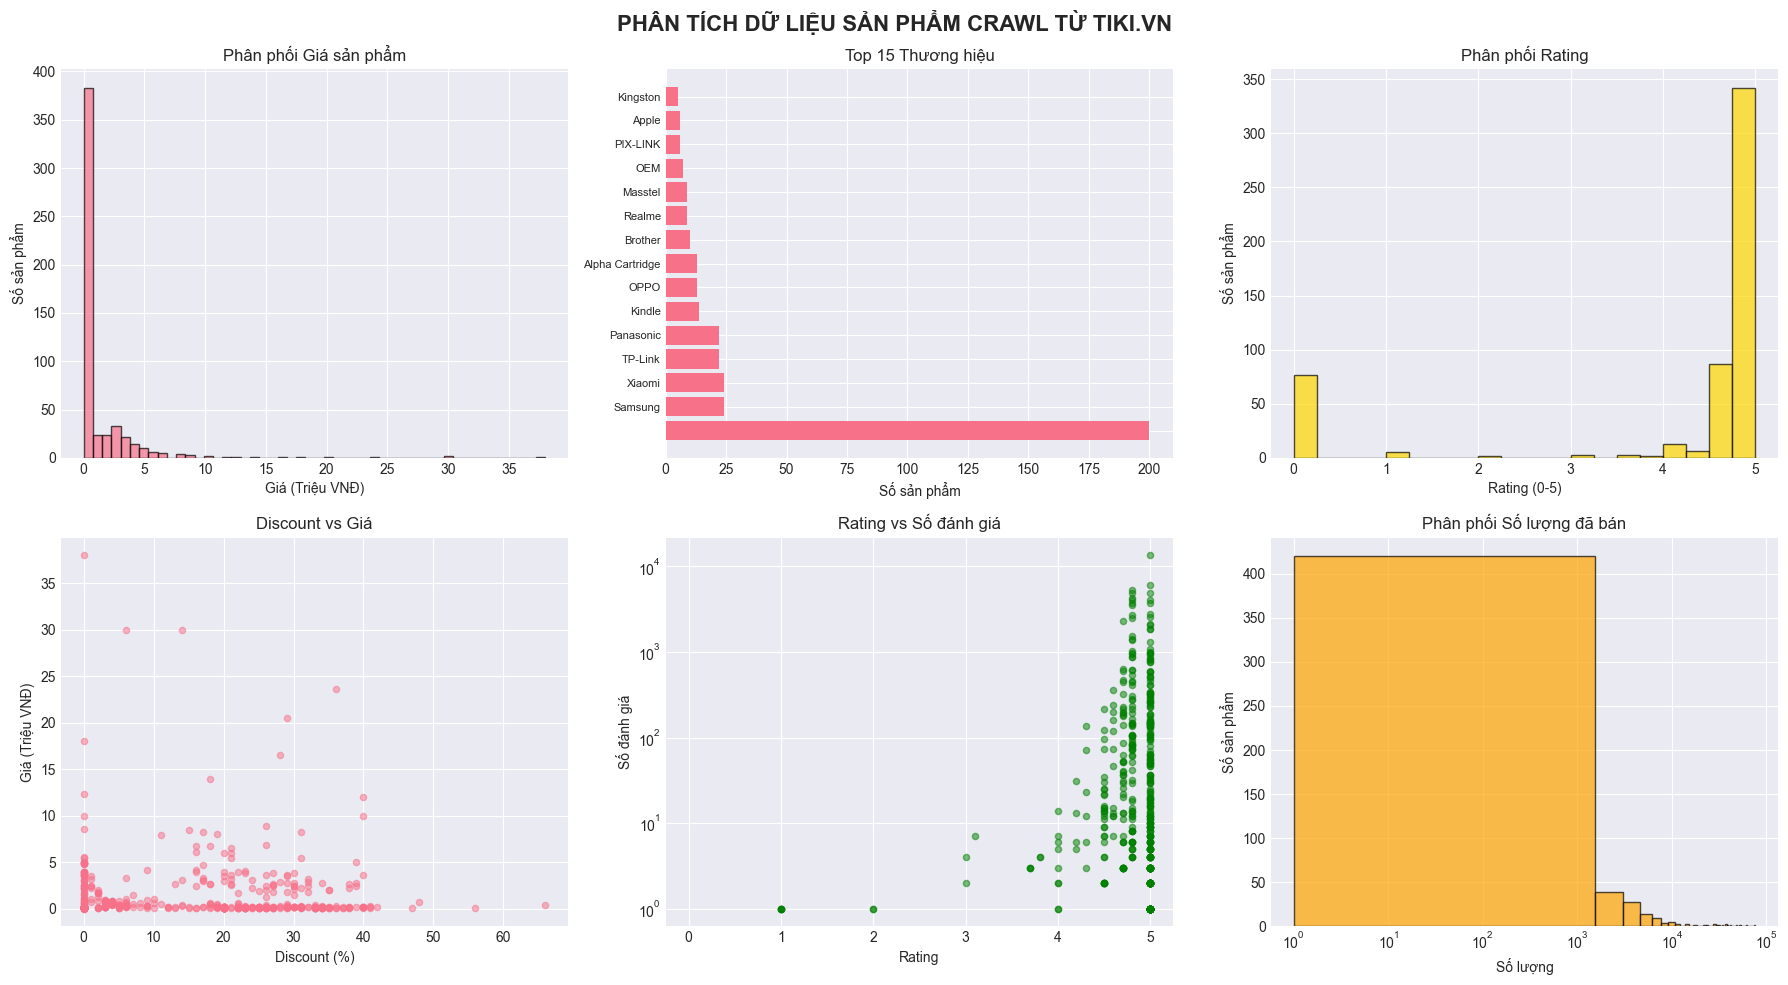

Đã lưu biểu đồ: '01_tiki_products_analysis.png'


In [7]:
print("\nTRỰC QUAN HÓA DỮ LIỆU SẢN PHẨM")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU SẢN PHẨM CRAWL TỪ TIKI.VN', fontsize=16, fontweight='bold')

# 1. Phân phối giá sản phẩm
axes[0, 0].hist(df_products['price'][df_products['price'] > 0]/1000000, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Giá sản phẩm')
axes[0, 0].set_xlabel('Giá (Triệu VNĐ)')
axes[0, 0].set_ylabel('Số sản phẩm')

# 2. Top 15 thương hiệu
top_brands = df_products['brand'].value_counts().head(15)
axes[0, 1].barh(range(len(top_brands)), top_brands.values)
axes[0, 1].set_yticks(range(len(top_brands)))
axes[0, 1].set_yticklabels(top_brands.index, fontsize=8)
axes[0, 1].set_title('Top 15 Thương hiệu')
axes[0, 1].set_xlabel('Số sản phẩm')

# 3. Phân phối Rating
axes[0, 2].hist(df_products['rating'], bins=20, edgecolor='black', alpha=0.7, color='gold')
axes[0, 2].set_title('Phân phối Rating')
axes[0, 2].set_xlabel('Rating (0-5)')
axes[0, 2].set_ylabel('Số sản phẩm')

# 4. Discount vs Price
axes[1, 0].scatter(df_products['discount'], df_products['price']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Discount vs Giá')
axes[1, 0].set_xlabel('Discount (%)')
axes[1, 0].set_ylabel('Giá (Triệu VNĐ)')

# 5. Rating vs Review Count
axes[1, 1].scatter(df_products['rating'], df_products['review_count'], alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Rating vs Số đánh giá')
axes[1, 1].set_xlabel('Rating')
axes[1, 1].set_ylabel('Số đánh giá')
axes[1, 1].set_yscale('log')

# 6. Sold Count Distribution
axes[1, 2].hist(df_products['sold_count'][df_products['sold_count'] > 0], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 2].set_title('Phân phối Số lượng đã bán')
axes[1, 2].set_xlabel('Số lượng')
axes[1, 2].set_ylabel('Số sản phẩm')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.savefig('01_tiki_products_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '01_tiki_products_analysis.png'")


TRỰC QUAN HÓA DỮ LIỆU GIAO DỊCH THÔ


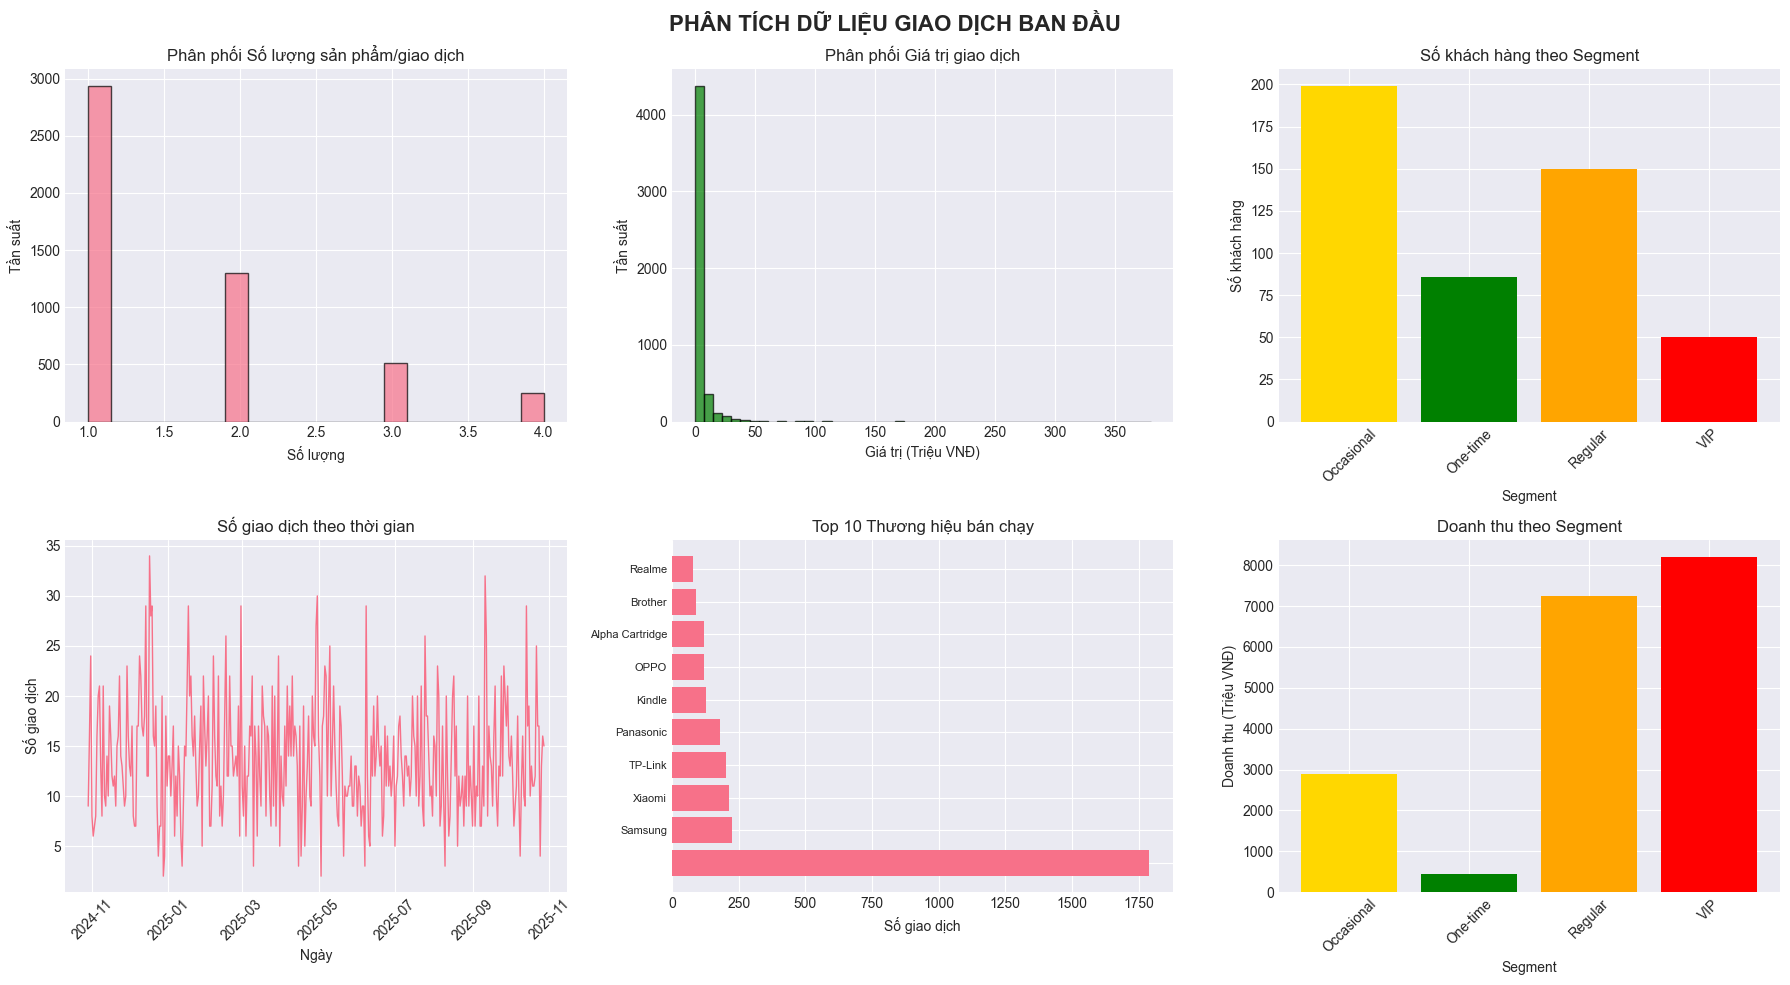

Đã lưu biểu đồ: '02_raw_transactions_visualization.png'


In [8]:
print("\nTRỰC QUAN HÓA DỮ LIỆU GIAO DỊCH THÔ")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('PHÂN TÍCH DỮ LIỆU GIAO DỊCH BAN ĐẦU', fontsize=16, fontweight='bold')

# 1. Phân phối số lượng mua
axes[0, 0].hist(df_raw['quantity'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân phối Số lượng sản phẩm/giao dịch')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')

# 2. Phân phối giá trị giao dịch
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')

# 3. Phân bố theo Customer Segment
segment_counts = df_raw.groupby('customer_segment')['customer_id'].nunique()
axes[0, 2].bar(segment_counts.index, segment_counts.values, color=['gold', 'green', 'orange', 'red'])
axes[0, 2].set_title('Số khách hàng theo Segment')
axes[0, 2].set_xlabel('Segment')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Giao dịch theo thời gian
df_raw['transaction_date'] = pd.to_datetime(df_raw['transaction_date'])
transactions_by_date = df_raw.groupby(df_raw['transaction_date'].dt.date).size()
axes[1, 0].plot(transactions_by_date.index, transactions_by_date.values, linewidth=1)
axes[1, 0].set_title('Số giao dịch theo thời gian')
axes[1, 0].set_xlabel('Ngày')
axes[1, 0].set_ylabel('Số giao dịch')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Top 10 thương hiệu được mua nhiều nhất
top_brands_sold = df_raw['brand'].value_counts().head(10)
axes[1, 1].barh(range(len(top_brands_sold)), top_brands_sold.values)
axes[1, 1].set_yticks(range(len(top_brands_sold)))
axes[1, 1].set_yticklabels(top_brands_sold.index, fontsize=8)
axes[1, 1].set_title('Top 10 Thương hiệu bán chạy')
axes[1, 1].set_xlabel('Số giao dịch')

# 6. Doanh thu theo segment
revenue_by_segment = df_raw.groupby('customer_segment')['total_amount'].sum()/1000000
axes[1, 2].bar(revenue_by_segment.index, revenue_by_segment.values, color=['gold', 'green', 'orange', 'red'])
axes[1, 2].set_title('Doanh thu theo Segment')
axes[1, 2].set_xlabel('Segment')
axes[1, 2].set_ylabel('Doanh thu (Triệu VNĐ)')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('02_raw_transactions_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '02_raw_transactions_visualization.png'")

In [9]:
print("\n" + "="*70)
print("PHÂN TÍCH TÍNH CHẤT DỮ LIỆU TRƯỚC KHI XỬ LÝ")
print("="*70)

print("\nTỔNG QUAN:")
print(f"   - Tổng số giao dịch: {len(df_raw):,}")
print(f"   - Tổng số cột: {len(df_raw.columns)}")
print(f"   - Bộ nhớ sử dụng: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nMISSING VALUES (Giá trị thiếu):")
missing_stats = pd.DataFrame({
    'Số lượng': df_raw.isnull().sum(),
    'Tỷ lệ (%)': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
print(missing_stats)

print("\nDUPLICATE VALUES (Giá trị trùng lặp):")
n_duplicates = df_raw.duplicated().sum()
print(f"   - Số giao dịch trùng lặp: {n_duplicates:,} ({n_duplicates/len(df_raw)*100:.2f}%)")

print("\nOUTLIERS (Giá trị bất thường):")
# Kiểm tra Quantity
q_negative = (df_raw['quantity'] < 0).sum()
q_zero = (df_raw['quantity'] == 0).sum()
print(f"   - Quantity âm: {q_negative:,}")
print(f"   - Quantity = 0: {q_zero:,}")

# Kiểm tra Price
p_negative = (df_raw['unit_price'] < 0).sum()
p_zero = (df_raw['unit_price'] == 0).sum()
print(f"   - Unit Price âm: {p_negative:,}")
print(f"   - Unit Price = 0: {p_zero:,}")

# Phát hiện outliers bằng IQR
Q1_qty = df_raw['quantity'].quantile(0.25)
Q3_qty = df_raw['quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
outliers_qty = ((df_raw['quantity'] < (Q1_qty - 1.5 * IQR_qty)) | 
                (df_raw['quantity'] > (Q3_qty + 1.5 * IQR_qty))).sum()
print(f"   - Outliers trong Quantity (IQR): {outliers_qty:,} ({outliers_qty/len(df_raw)*100:.2f}%)")

Q1_price = df_raw['total_amount'].quantile(0.25)
Q3_price = df_raw['total_amount'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outliers_price = ((df_raw['total_amount'] < (Q1_price - 1.5 * IQR_price)) | 
                  (df_raw['total_amount'] > (Q3_price + 1.5 * IQR_price))).sum()
print(f"   - Outliers trong Total Amount (IQR): {outliers_price:,} ({outliers_price/len(df_raw)*100:.2f}%)")

print("\nDATA TYPES (Kiểu dữ liệu):")
print(df_raw.dtypes)

print("\nSTATISTICAL SUMMARY (Thống kê mô tả):")
print(df_raw[['quantity', 'unit_price', 'total_amount', 'rating']].describe())

print("\nBUSINESS INSIGHTS:")
print(f"   - Giao dịch trung bình/khách: {len(df_raw)/df_raw['customer_id'].nunique():.2f}")
print(f"   - Giá trị trung bình/giao dịch: {df_raw['total_amount'].mean():,.0f} VNĐ")
print(f"   - Tổng doanh thu: {df_raw['total_amount'].sum():,.0f} VNĐ")


PHÂN TÍCH TÍNH CHẤT DỮ LIỆU TRƯỚC KHI XỬ LÝ

TỔNG QUAN:
   - Tổng số giao dịch: 5,000
   - Tổng số cột: 11
   - Bộ nhớ sử dụng: 2.07 MB

MISSING VALUES (Giá trị thiếu):
                  Số lượng  Tỷ lệ (%)
transaction_id           0        0.0
customer_id              0        0.0
product_id               0        0.0
product_name             0        0.0
quantity                 0        0.0
unit_price               0        0.0
total_amount             0        0.0
transaction_date         0        0.0
brand                    0        0.0
rating                   0        0.0
customer_segment         0        0.0

DUPLICATE VALUES (Giá trị trùng lặp):
   - Số giao dịch trùng lặp: 0 (0.00%)

OUTLIERS (Giá trị bất thường):
   - Quantity âm: 0
   - Quantity = 0: 0
   - Unit Price âm: 0
   - Unit Price = 0: 0
   - Outliers trong Quantity (IQR): 248 (4.96%)
   - Outliers trong Total Amount (IQR): 712 (14.24%)

DATA TYPES (Kiểu dữ liệu):
transaction_id              object
customer_id   

          quantity    unit_price  total_amount       rating
count  5000.000000  5.000000e+03  5.000000e+03  5000.000000
mean      1.615800  2.323449e+06  3.757315e+06     4.084120
std       0.860894  5.788462e+06  1.179390e+07     1.737238
min       1.000000  7.000000e+03  7.000000e+03     0.000000
25%       1.000000  1.729500e+05  2.250000e+05     4.500000
50%       1.000000  3.447060e+05  5.460000e+05     4.800000
75%       2.000000  2.150000e+06  2.904250e+06     5.000000
max       4.000000  9.497500e+07  3.799000e+08     5.000000

BUSINESS INSIGHTS:
   - Giao dịch trung bình/khách: 10.31
   - Giá trị trung bình/giao dịch: 3,757,315 VNĐ
   - Tổng doanh thu: 18,786,577,097 VNĐ


In [10]:
print("\n" + "="*70)
print("THỰC HIỆN TIỀN XỬ LÝ DỮ LIỆU")
print("="*70)

df_clean = df_raw.copy()
initial_rows = len(df_clean)

print("\nBước 1: Xử lý Missing Values")
before_missing = df_clean.isnull().sum().sum()
df_clean = df_clean.dropna()
after_missing = df_clean.isnull().sum().sum()
print(f"   - Loại bỏ: {before_missing - after_missing:,} missing values")
print(f"   - Còn lại: {len(df_clean):,} giao dịch ({len(df_clean)/initial_rows*100:.2f}%)")

print("\nBước 2: Loại bỏ Duplicates")
before_dup = len(df_clean)
df_clean = df_clean.drop_duplicates()
removed_dup = before_dup - len(df_clean)
print(f"   - Loại bỏ: {removed_dup:,} giao dịch trùng lặp")
print(f"   - Còn lại: {len(df_clean):,} giao dịch")

print("\nBước 3: Xử lý Outliers và Invalid Values")
before_outliers = len(df_clean)

# Loại bỏ giá trị âm và zero
df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['unit_price'] > 0)]

# Loại bỏ outliers cực đoan (> 99th percentile hoặc < 1st percentile)
df_clean = df_clean[df_clean['quantity'] <= df_clean['quantity'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] <= df_clean['total_amount'].quantile(0.99)]
df_clean = df_clean[df_clean['total_amount'] >= df_clean['total_amount'].quantile(0.01)]

removed_outliers = before_outliers - len(df_clean)
print(f"   - Loại bỏ: {removed_outliers:,} outliers và invalid values")
print(f"   - Còn lại: {len(df_clean):,} giao dịch")

print("\nBước 4: Chuẩn hóa dữ liệu")
df_clean['transaction_date'] = pd.to_datetime(df_clean['transaction_date'])
df_clean['customer_id'] = df_clean['customer_id'].astype(int)
df_clean['product_id'] = df_clean['product_id'].astype(str)

print("   - Đã chuẩn hóa kiểu dữ liệu")

print(f"\nTỔNG KẾT TIỀN XỬ LÝ:")
print(f"   - Số giao dịch ban đầu: {initial_rows:,}")
print(f"   - Số giao dịch sau xử lý: {len(df_clean):,}")
print(f"   - Tỷ lệ giữ lại: {len(df_clean)/initial_rows*100:.2f}%")
print(f"   - Số giao dịch bị loại: {initial_rows - len(df_clean):,}")

df_clean.to_csv('cleaned_transactions.csv', index=False, encoding='utf-8-sig')
print("\nĐã lưu dữ liệu sạch vào 'cleaned_transactions.csv'")


THỰC HIỆN TIỀN XỬ LÝ DỮ LIỆU

Bước 1: Xử lý Missing Values
   - Loại bỏ: 0 missing values
   - Còn lại: 5,000 giao dịch (100.00%)

Bước 2: Loại bỏ Duplicates
   - Loại bỏ: 0 giao dịch trùng lặp
   - Còn lại: 5,000 giao dịch

Bước 3: Xử lý Outliers và Invalid Values
   - Loại bỏ: 99 outliers và invalid values
   - Còn lại: 4,901 giao dịch

Bước 4: Chuẩn hóa dữ liệu
   - Đã chuẩn hóa kiểu dữ liệu

TỔNG KẾT TIỀN XỬ LÝ:
   - Số giao dịch ban đầu: 5,000
   - Số giao dịch sau xử lý: 4,901
   - Tỷ lệ giữ lại: 98.02%
   - Số giao dịch bị loại: 99

Đã lưu dữ liệu sạch vào 'cleaned_transactions.csv'


In [11]:
print("\n" + "="*70)
print("PHÂN TÍCH TÍNH CHẤT DỮ LIỆU SAU KHI XỬ LÝ")
print("="*70)

print("\nTỔNG QUAN:")
print(f"   - Tổng số giao dịch: {len(df_clean):,}")
print(f"   - Tổng số cột: {len(df_clean.columns)}")
print(f"   - Bộ nhớ sử dụng: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nMISSING VALUES:")
missing_after = df_clean.isnull().sum().sum()
print(f"   - Tổng missing values: {missing_after}")

print("\nDUPLICATE VALUES:")
dup_after = df_clean.duplicated().sum()
print(f"   - Số giao dịch trùng lặp: {dup_after}")

print("\nOUTLIERS:")
print(f"   - Quantity âm: {(df_clean['quantity'] < 0).sum()}")
print(f"   - Quantity = 0: {(df_clean['quantity'] == 0).sum()}")
print(f"   - Unit Price âm: {(df_clean['unit_price'] < 0).sum()}")
print(f"   - Unit Price = 0: {(df_clean['unit_price'] == 0).sum()}")

print("\nDATA TYPES:")
print(df_clean.dtypes)

print("\nSTATISTICAL SUMMARY:")
print(df_clean[['quantity', 'unit_price', 'total_amount', 'rating']].describe())

print("\nSO SÁNH TRƯỚC VÀ SAU XỬ LÝ:")
comparison = pd.DataFrame({
    'Metric': ['Số giao dịch', 'Missing Values', 'Duplicates', 'Outliers'],
    'Trước': [initial_rows, before_missing, n_duplicates, outliers_qty + outliers_price],
    'Sau': [len(df_clean), missing_after, dup_after, 0],
    'Giảm': [initial_rows - len(df_clean), before_missing - missing_after, 
             n_duplicates - dup_after, outliers_qty + outliers_price]
})
print(comparison.to_string(index=False))


PHÂN TÍCH TÍNH CHẤT DỮ LIỆU SAU KHI XỬ LÝ

TỔNG QUAN:
   - Tổng số giao dịch: 4,901
   - Tổng số cột: 11
   - Bộ nhớ sử dụng: 2.65 MB

MISSING VALUES:
   - Tổng missing values: 0

DUPLICATE VALUES:
   - Số giao dịch trùng lặp: 0

OUTLIERS:
   - Quantity âm: 0
   - Quantity = 0: 0
   - Unit Price âm: 0
   - Unit Price = 0: 0

DATA TYPES:
transaction_id              object
customer_id                  int64
product_id                  object
product_name                object
quantity                     int64
unit_price                 float64
total_amount               float64
transaction_date    datetime64[ns]
brand                       object
rating                     float64
customer_segment            object
dtype: object

STATISTICAL SUMMARY:
          quantity    unit_price  total_amount       rating
count  4901.000000  4.901000e+03  4.901000e+03  4901.000000
mean      1.611304  1.967401e+06  2.961522e+06     4.092695
std       0.855061  3.900370e+06  5.824660e+06     1.725899

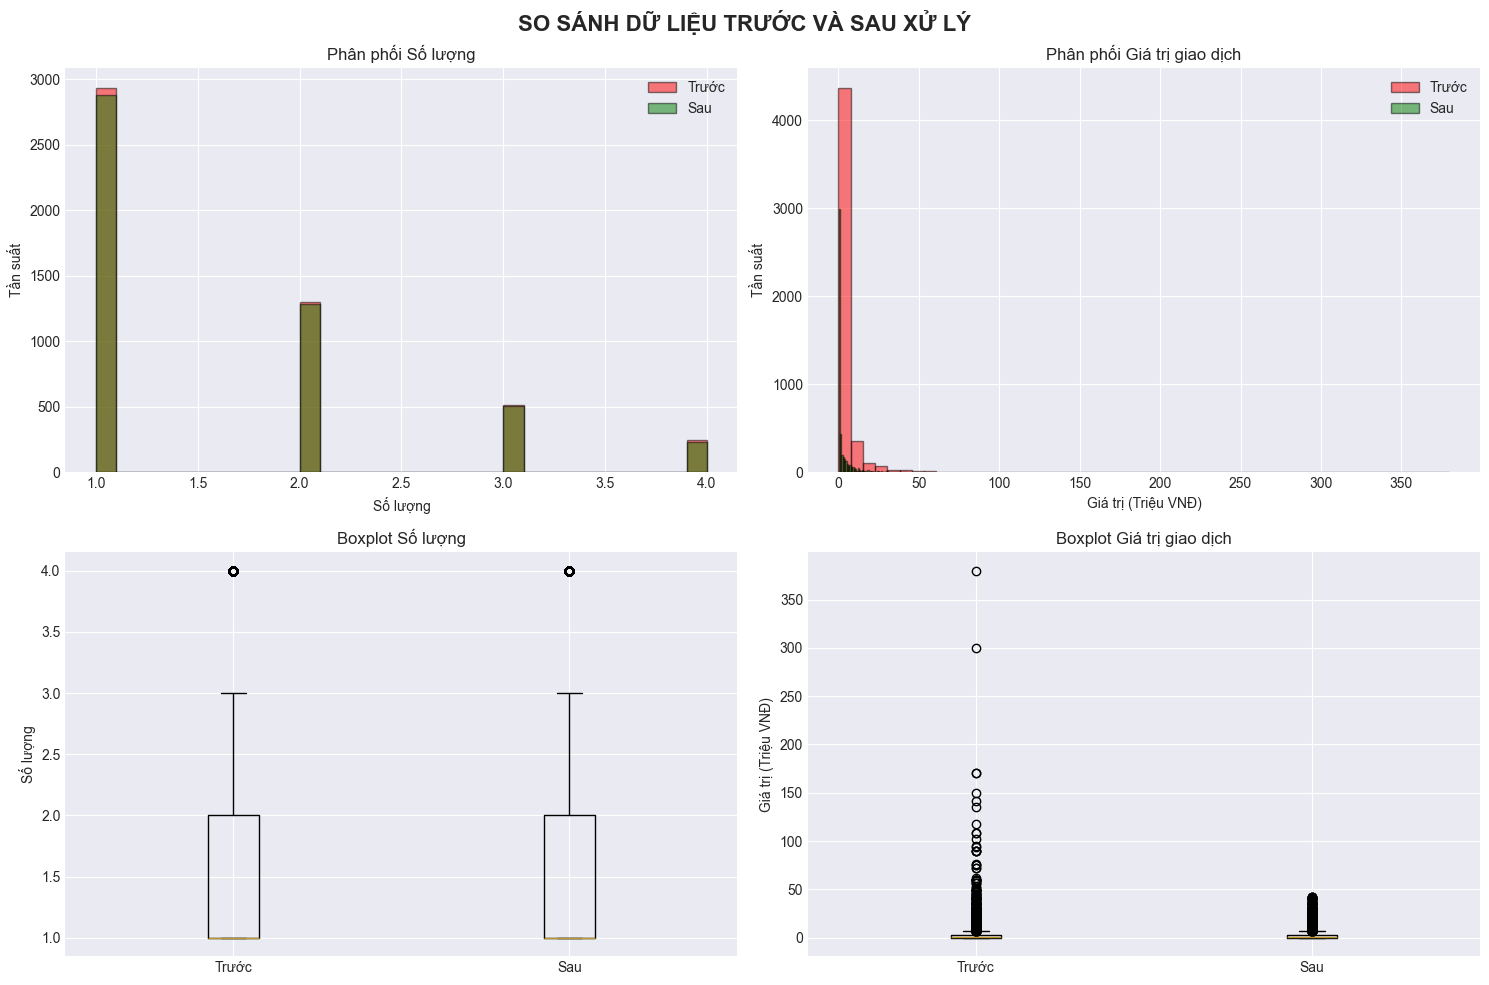

Đã lưu biểu đồ: '03_before_after_comparison.png'


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SO SÁNH DỮ LIỆU TRƯỚC VÀ SAU XỬ LÝ', fontsize=16, fontweight='bold')

# 1. Phân phối Quantity
axes[0, 0].hist(df_raw['quantity'], bins=30, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 0].hist(df_clean['quantity'], bins=30, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 0].set_title('Phân phối Số lượng')
axes[0, 0].set_xlabel('Số lượng')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].legend()

# 2. Phân phối Total Amount
axes[0, 1].hist(df_raw['total_amount']/1000000, bins=50, alpha=0.5, label='Trước', color='red', edgecolor='black')
axes[0, 1].hist(df_clean['total_amount']/1000000, bins=50, alpha=0.5, label='Sau', color='green', edgecolor='black')
axes[0, 1].set_title('Phân phối Giá trị giao dịch')
axes[0, 1].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 1].set_ylabel('Tần suất')
axes[0, 1].legend()

# 3. Boxplot Quantity
axes[1, 0].boxplot([df_raw['quantity'], df_clean['quantity']], 
                    labels=['Trước', 'Sau'])
axes[1, 0].set_title('Boxplot Số lượng')
axes[1, 0].set_ylabel('Số lượng')

# 4. Boxplot Total Amount
axes[1, 1].boxplot([df_raw['total_amount']/1000000, df_clean['total_amount']/1000000], 
                    labels=['Trước', 'Sau'])
axes[1, 1].set_title('Boxplot Giá trị giao dịch')
axes[1, 1].set_ylabel('Giá trị (Triệu VNĐ)')

plt.tight_layout()
plt.savefig('03_before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '03_before_after_comparison.png'")

In [13]:
print("\n" + "="*70)
print("BƯỚC 4: TẠO RFM FEATURES (Recency, Frequency, Monetary)")
print("="*70)

# Tính ngày reference (ngày cuối cùng trong dataset + 1)
reference_date = df_clean['transaction_date'].max() + timedelta(days=1)
print(f"Reference Date: {reference_date}")

# Tính RFM cho mỗi khách hàng
rfm = df_clean.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
    'transaction_id': 'nunique',  # Frequency
    'total_amount': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Thêm các feature bổ sung
customer_extra = df_clean.groupby('customer_id').agg({
    'quantity': 'sum',  # Tổng số sản phẩm đã mua
    'rating': 'mean',  # Rating trung bình của sản phẩm đã mua
    'brand': lambda x: x.nunique()  # Số lượng thương hiệu khác nhau
}).reset_index()

customer_extra.columns = ['CustomerID', 'TotalProducts', 'AvgRating', 'BrandDiversity']

# Merge RFM với features bổ sung
rfm = rfm.merge(customer_extra, on='CustomerID')

# Tính thêm Average Order Value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

print(f"\nĐã tạo RFM features cho {len(rfm)} khách hàng")
print("\nCác features đã tạo:")
print(rfm.columns.tolist())

print("\nThống kê RFM:")
print(rfm.describe())

print("\nMẫu dữ liệu RFM:")
display(rfm.head(10))

rfm.to_csv('rfm_features.csv', index=False, encoding='utf-8-sig')
print("\nĐã lưu RFM features vào 'rfm_features.csv'")


BƯỚC 4: TẠO RFM FEATURES (Recency, Frequency, Monetary)
Reference Date: 2025-10-29 19:41:16.654419

Đã tạo RFM features cho 483 khách hàng

Các features đã tạo:
['CustomerID', 'Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']

Thống kê RFM:
         CustomerID     Recency   Frequency      Monetary  TotalProducts  \
count    483.000000  483.000000  483.000000  4.830000e+02     483.000000   
mean   10242.734990   89.942029   10.146998  3.005056e+07      16.349896   
std      142.142294   92.021899    9.349214  4.224685e+07      15.305727   
min    10000.000000    1.000000    1.000000  8.400000e+04       1.000000   
25%    10120.500000   20.000000    4.000000  4.000002e+06       6.000000   
50%    10241.000000   54.000000    8.000000  1.417240e+07      12.000000   
75%    10362.500000  131.500000   14.000000  3.888304e+07      21.000000   
max    10499.000000  363.000000   60.000000  2.931066e+08     106.000000   

        AvgRating  Bra

,CustomerID,Recency,Frequency,Monetary,TotalProducts,AvgRating,BrandDiversity,AvgOrderValue
0,10000,19,27,117160102.5,40,4.007407,16,4.339263e+06
1,10001,45,26,66247462.5,35,4.046154,13,2.547979e+06
2,10002,6,24,127604520.0,35,4.266667,14,5.316855e+06
3,10003,5,41,101700700.0,69,3.695122,24,2.480505e+06
4,10004,20,32,137115277.5,54,4.456250,21,4.284852e+06
5,10005,30,45,241293705.0,72,4.491111,24,5.362082e+06
6,10006,6,43,140294002.5,58,3.993023,15,3.262651e+06
7,10007,17,42,181981295.0,72,4.354762,24,4.332888e+06
8,10008,56,28,101572325.0,40,3.871429,19,3.627583e+06
9,10009,30,33,109196675.0,57,3.675758,18,3.308990e+06



Đã lưu RFM features vào 'rfm_features.csv'



BƯỚC 5: KHAI PHÁ DỮ LIỆU (EXPLORATORY DATA ANALYSIS)


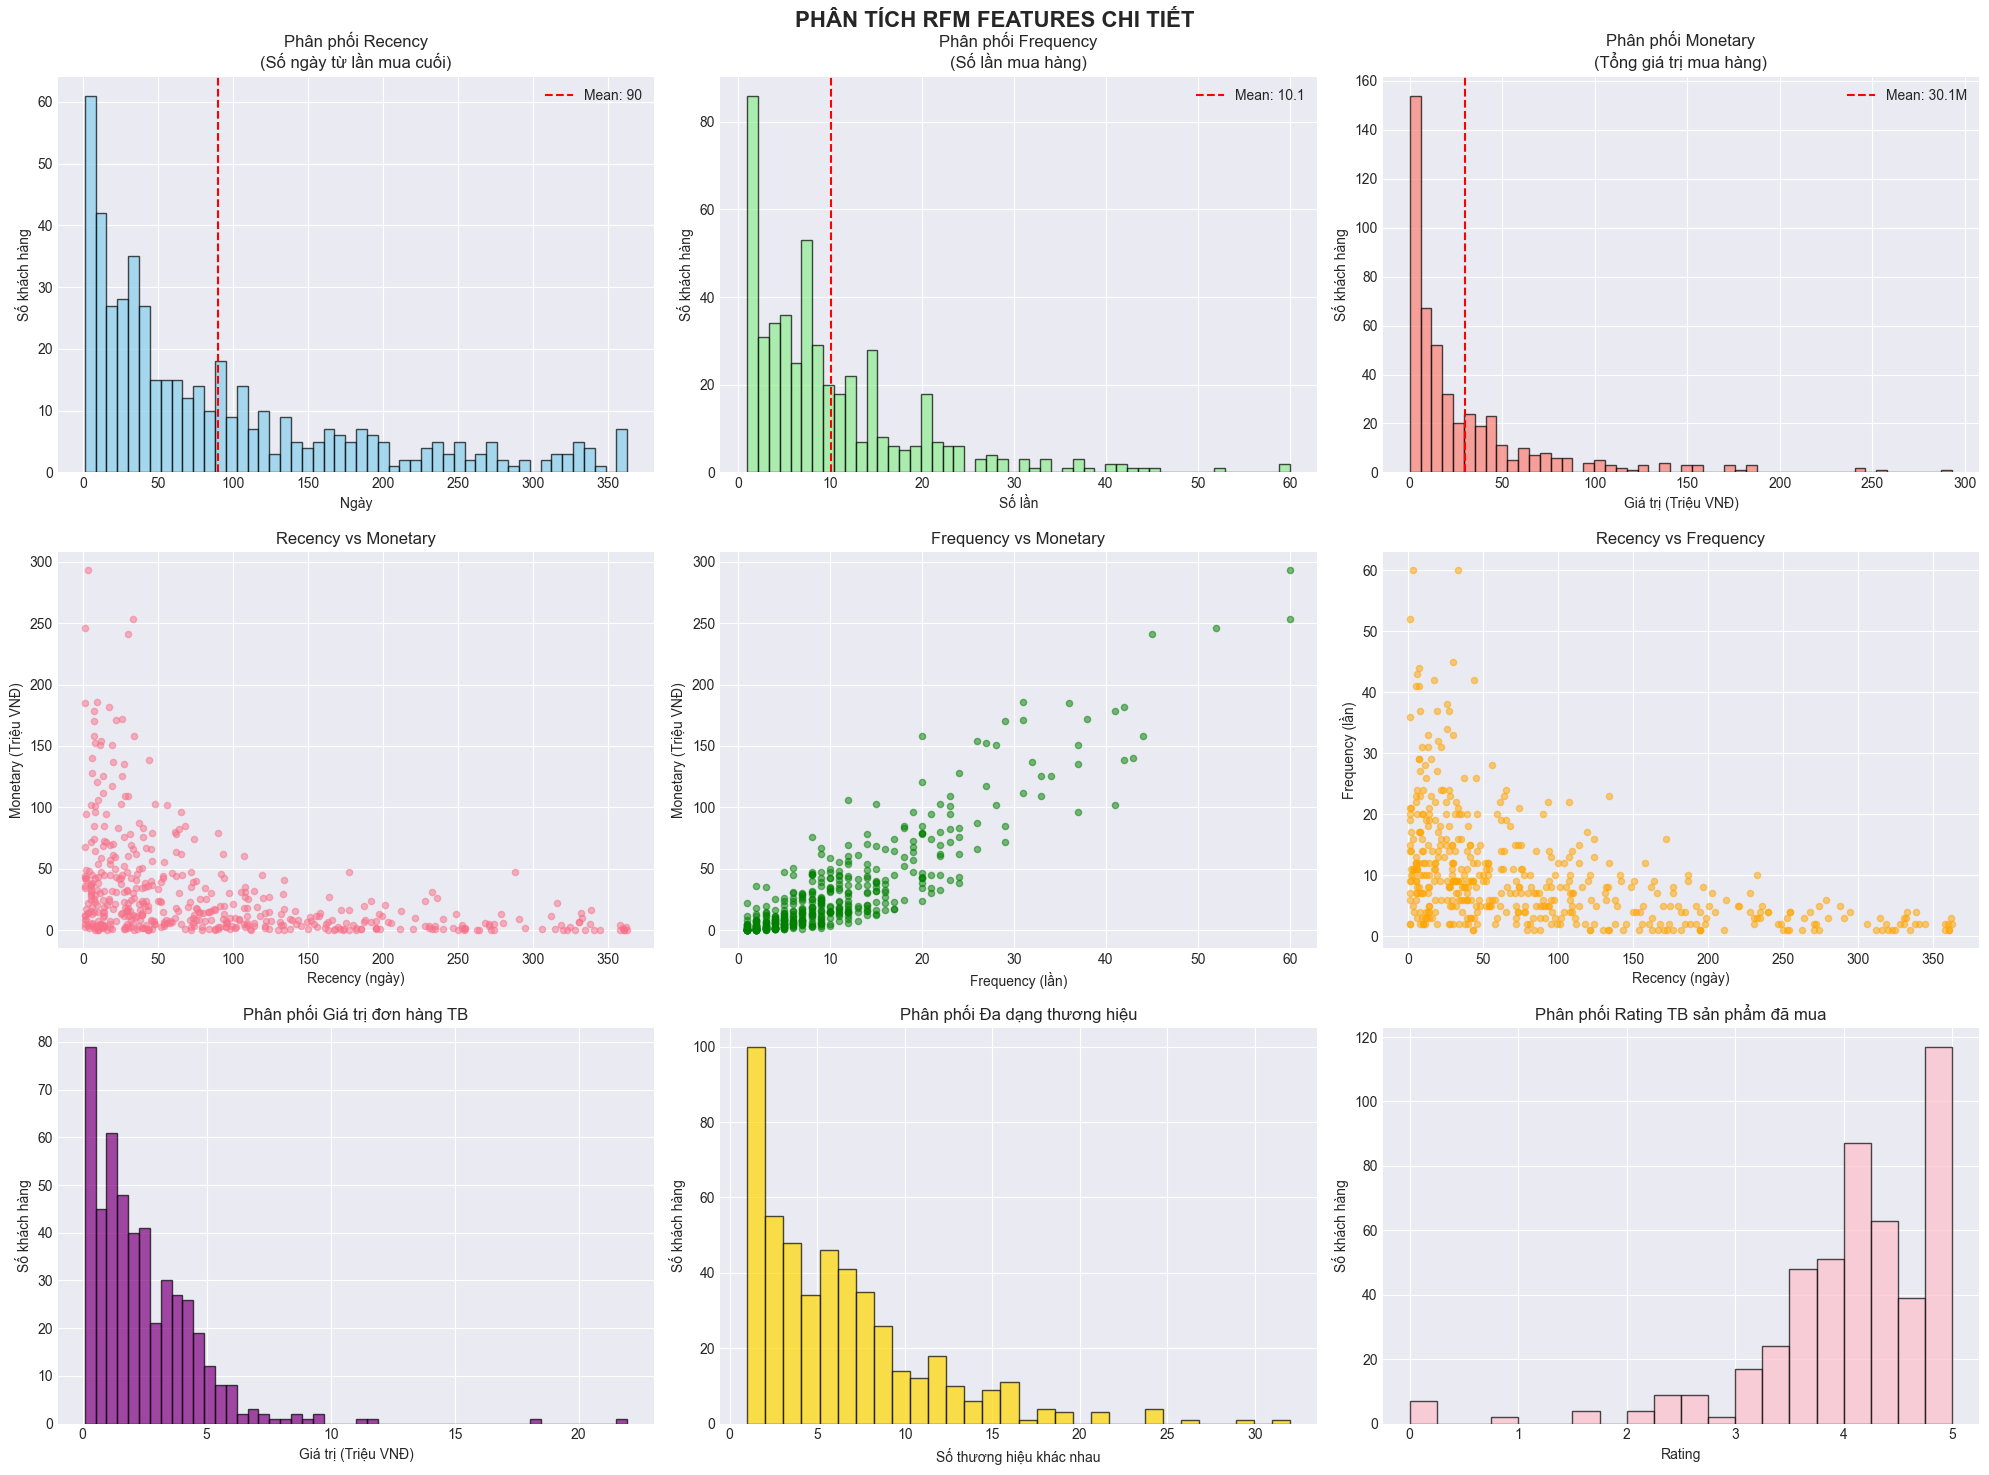

Đã lưu biểu đồ: '04_rfm_analysis.png'


In [14]:
print("\n" + "="*70)
print("BƯỚC 5: KHAI PHÁ DỮ LIỆU (EXPLORATORY DATA ANALYSIS)")
print("="*70)

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('PHÂN TÍCH RFM FEATURES CHI TIẾT', fontsize=16, fontweight='bold')

# 1. Phân phối Recency
axes[0, 0].hist(rfm['Recency'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Phân phối Recency\n(Số ngày từ lần mua cuối)')
axes[0, 0].set_xlabel('Ngày')
axes[0, 0].set_ylabel('Số khách hàng')
axes[0, 0].axvline(rfm['Recency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Recency"].mean():.0f}')
axes[0, 0].legend()

# 2. Phân phối Frequency
axes[0, 1].hist(rfm['Frequency'], bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Phân phối Frequency\n(Số lần mua hàng)')
axes[0, 1].set_xlabel('Số lần')
axes[0, 1].set_ylabel('Số khách hàng')
axes[0, 1].axvline(rfm['Frequency'].mean(), color='red', linestyle='--', label=f'Mean: {rfm["Frequency"].mean():.1f}')
axes[0, 1].legend()

# 3. Phân phối Monetary
axes[0, 2].hist(rfm['Monetary']/1000000, bins=50, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].set_title('Phân phối Monetary\n(Tổng giá trị mua hàng)')
axes[0, 2].set_xlabel('Giá trị (Triệu VNĐ)')
axes[0, 2].set_ylabel('Số khách hàng')
axes[0, 2].axvline(rfm['Monetary'].mean()/1000000, color='red', linestyle='--', label=f'Mean: {rfm["Monetary"].mean()/1000000:.1f}M')
axes[0, 2].legend()

# 4. Scatter: Recency vs Monetary
axes[1, 0].scatter(rfm['Recency'], rfm['Monetary']/1000000, alpha=0.5, s=20)
axes[1, 0].set_title('Recency vs Monetary')
axes[1, 0].set_xlabel('Recency (ngày)')
axes[1, 0].set_ylabel('Monetary (Triệu VNĐ)')

# 5. Scatter: Frequency vs Monetary
axes[1, 1].scatter(rfm['Frequency'], rfm['Monetary']/1000000, alpha=0.5, s=20, color='green')
axes[1, 1].set_title('Frequency vs Monetary')
axes[1, 1].set_xlabel('Frequency (lần)')
axes[1, 1].set_ylabel('Monetary (Triệu VNĐ)')

# 6. Scatter: Recency vs Frequency
axes[1, 2].scatter(rfm['Recency'], rfm['Frequency'], alpha=0.5, s=20, color='orange')
axes[1, 2].set_title('Recency vs Frequency')
axes[1, 2].set_xlabel('Recency (ngày)')
axes[1, 2].set_ylabel('Frequency (lần)')

# 7. Phân phối Average Order Value
axes[2, 0].hist(rfm['AvgOrderValue']/1000000, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[2, 0].set_title('Phân phối Giá trị đơn hàng TB')
axes[2, 0].set_xlabel('Giá trị (Triệu VNĐ)')
axes[2, 0].set_ylabel('Số khách hàng')

# 8. Phân phối Brand Diversity
axes[2, 1].hist(rfm['BrandDiversity'], bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[2, 1].set_title('Phân phối Đa dạng thương hiệu')
axes[2, 1].set_xlabel('Số thương hiệu khác nhau')
axes[2, 1].set_ylabel('Số khách hàng')

# 9. Phân phối Average Rating
axes[2, 2].hist(rfm['AvgRating'], bins=20, edgecolor='black', alpha=0.7, color='pink')
axes[2, 2].set_title('Phân phối Rating TB sản phẩm đã mua')
axes[2, 2].set_xlabel('Rating')
axes[2, 2].set_ylabel('Số khách hàng')

plt.tight_layout()
plt.savefig('04_rfm_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '04_rfm_analysis.png'")


MA TRẬN TƯƠNG QUAN:


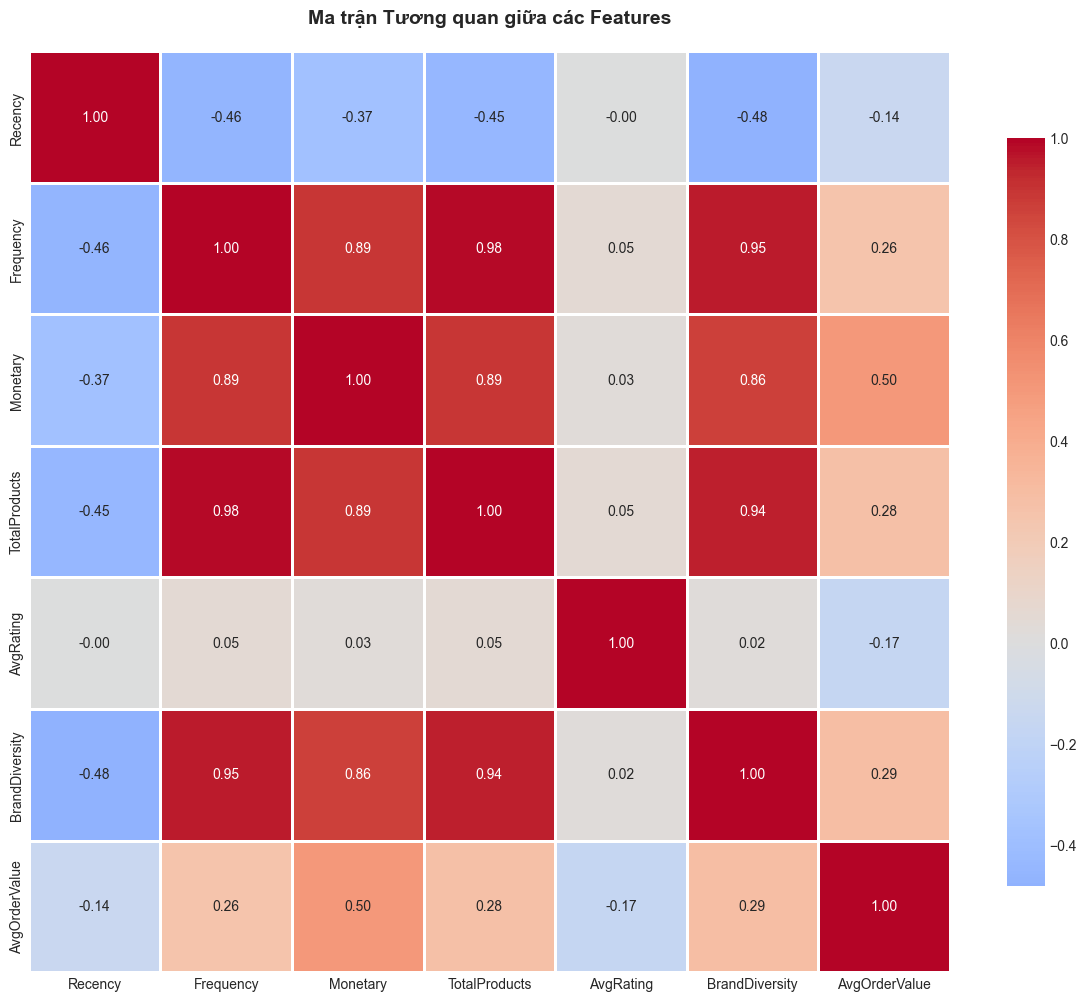

Đã lưu biểu đồ: '05_correlation_matrix.png'

PHÂN TÍCH TƯƠNG QUAN CHỦ YẾU:

Tương quan mạnh (|r| > 0.7):
   Frequency <-> Monetary: 0.893
   Frequency <-> TotalProducts: 0.984
   Frequency <-> BrandDiversity: 0.953
   Monetary <-> TotalProducts: 0.895
   Monetary <-> BrandDiversity: 0.861
   TotalProducts <-> BrandDiversity: 0.942

Tương quan trung bình (0.4 < |r| < 0.7):
   Recency <-> Frequency: -0.458
   Recency <-> TotalProducts: -0.450
   Recency <-> BrandDiversity: -0.481
   Monetary <-> AvgOrderValue: 0.499


In [15]:
print("\nMA TRẬN TƯƠNG QUAN:")

# Chọn các cột số để phân tích tương quan
numeric_cols = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'AvgRating', 'BrandDiversity', 'AvgOrderValue']
correlation_matrix = rfm[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Ma trận Tương quan giữa các Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('05_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '05_correlation_matrix.png'")

print("\nPHÂN TÍCH TƯƠNG QUAN CHỦ YẾU:")
print("\nTương quan mạnh (|r| > 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")

print("\nTương quan trung bình (0.4 < |r| < 0.7):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if 0.4 < abs(corr_value) <= 0.7:
            print(f"   {correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {corr_value:.3f}")


In [16]:
print("\n" + "="*70)
print("BƯỚC 6: CHUẨN BỊ DỮ LIỆU CHO THUẬT TOÁN PHÂN CỤM")
print("="*70)

# Chọn features cho clustering (loại bỏ CustomerID)
features_for_clustering = ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
X = rfm[features_for_clustering].copy()

print(f"Features sử dụng cho clustering: {features_for_clustering}")
print(f"Kích thước dữ liệu: {X.shape}")

# Log transform cho các features có phân phối lệch
print("\nÁp dụng Log Transformation cho các features:")
X['Monetary_log'] = np.log1p(X['Monetary'])
X['AvgOrderValue_log'] = np.log1p(X['AvgOrderValue'])
X = X.drop(['Monetary', 'AvgOrderValue'], axis=1)

print("Đã transform Monetary và AvgOrderValue")

# Kiểm tra và xử lý outliers bằng IQR
print("\nXử lý outliers bằng phương pháp IQR:")
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    outliers_count = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    if outliers_count > 0:
        print(f"   {col}: {outliers_count} outliers detected")
        X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

# Chuẩn hóa dữ liệu (Standardization)
print("\nChuẩn hóa dữ liệu (StandardScaler):")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Đã chuẩn hóa dữ liệu")
print("\nThống kê sau chuẩn hóa (Mean ≈ 0, Std ≈ 1):")
print(X_scaled_df.describe())


BƯỚC 6: CHUẨN BỊ DỮ LIỆU CHO THUẬT TOÁN PHÂN CỤM
Features sử dụng cho clustering: ['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']
Kích thước dữ liệu: (483, 6)

Áp dụng Log Transformation cho các features:
Đã transform Monetary và AvgOrderValue

Xử lý outliers bằng phương pháp IQR:
   Frequency: 4 outliers detected
   TotalProducts: 7 outliers detected
   BrandDiversity: 2 outliers detected

Chuẩn hóa dữ liệu (StandardScaler):
Đã chuẩn hóa dữ liệu

Thống kê sau chuẩn hóa (Mean ≈ 0, Std ≈ 1):
            Recency     Frequency  TotalProducts  BrandDiversity  \
count  4.830000e+02  4.830000e+02   4.830000e+02    4.830000e+02   
mean  -5.884412e-17 -5.884412e-17   1.176882e-16    1.176882e-16   
std    1.001037e+00  1.001037e+00   1.001037e+00    1.001037e+00   
min   -9.675332e-01 -1.011421e+00  -1.061285e+00   -1.140063e+00   
25%   -7.608466e-01 -6.765913e-01  -7.100922e-01   -7.277449e-01   
50%   -3.909862e-01 -2.301520e-01  -2.886613e-01   -1.


BƯỚC 7: TÌM SỐ CLUSTER TỐI ƯU

Phương pháp 1: ELBOW METHOD
   K=2: Inertia = 1628.15
   K=3: Inertia = 1087.19
   K=4: Inertia = 869.17
   K=5: Inertia = 707.55
   K=6: Inertia = 572.81
   K=7: Inertia = 506.52
   K=8: Inertia = 454.42
   K=9: Inertia = 418.58
   K=10: Inertia = 385.12


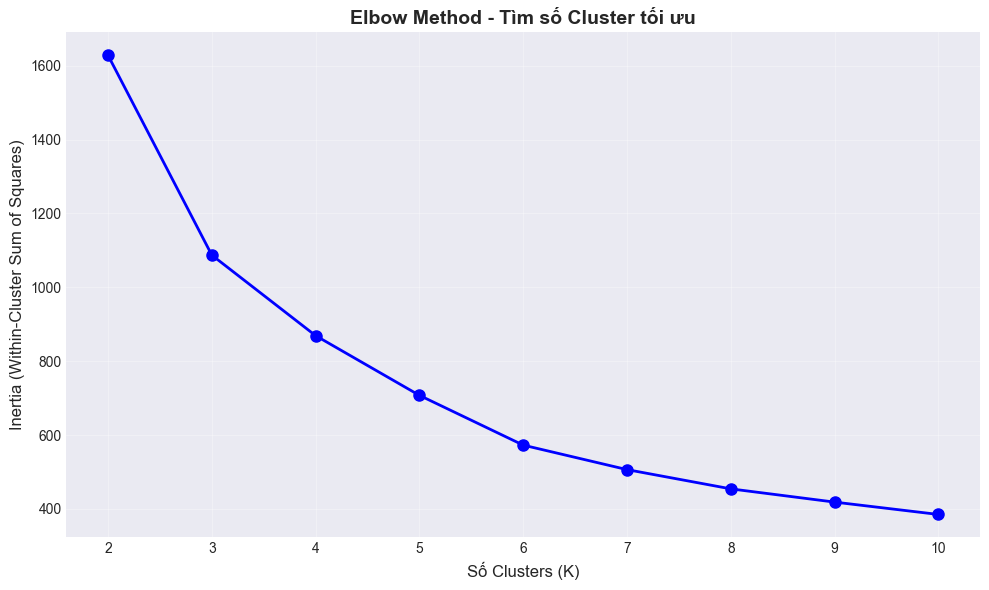

Đã lưu biểu đồ: '06_elbow_method.png'


In [17]:
print("\n" + "="*70)
print("BƯỚC 7: TÌM SỐ CLUSTER TỐI ƯU")
print("="*70)

print("\nPhương pháp 1: ELBOW METHOD")

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"   K={k}: Inertia = {kmeans.inertia_:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Số Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method - Tìm số Cluster tối ưu', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('06_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '06_elbow_method.png'")


Phương pháp 2: SILHOUETTE SCORE
   K=2: Silhouette Score = 0.3650
   K=3: Silhouette Score = 0.3596
   K=4: Silhouette Score = 0.3028
   K=5: Silhouette Score = 0.3257
   K=6: Silhouette Score = 0.3284
   K=7: Silhouette Score = 0.3030
   K=8: Silhouette Score = 0.2901
   K=9: Silhouette Score = 0.2829
   K=10: Silhouette Score = 0.2850


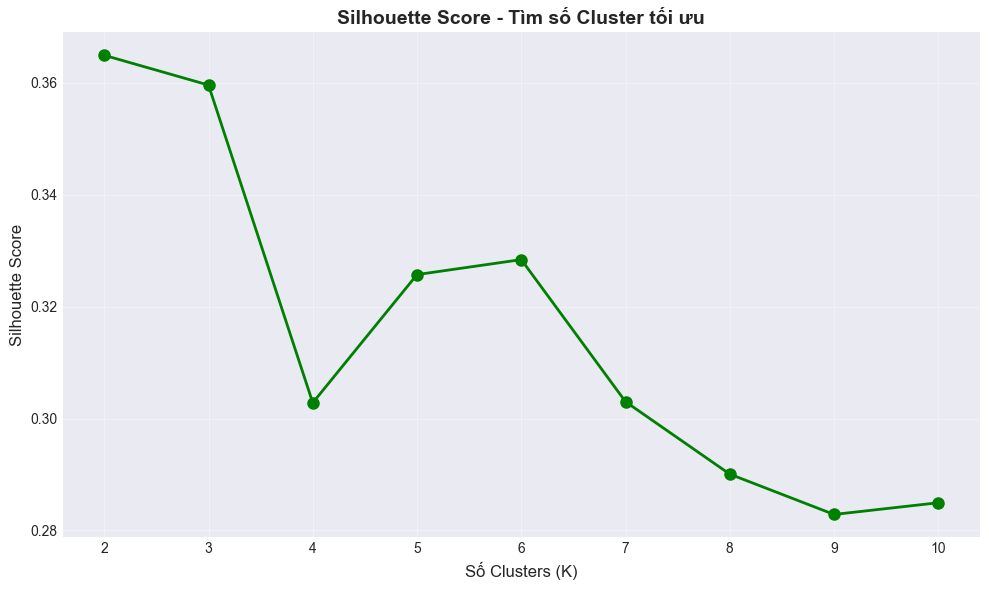

Đã lưu biểu đồ: '07_silhouette_score.png'

SỐ CLUSTER TỐI ƯU: K = 2 (Silhouette Score = 0.3650)


In [18]:
print("\nPhương pháp 2: SILHOUETTE SCORE")

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"   K={k}: Silhouette Score = {score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Số Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score - Tìm số Cluster tối ưu', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('07_silhouette_score.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '07_silhouette_score.png'")

# Tìm K tốt nhất
best_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSỐ CLUSTER TỐI ƯU: K = {best_k} (Silhouette Score = {max(silhouette_scores):.4f})")


In [19]:
print("\n" + "="*70)
print(f"BƯỚC 8: ÁP DỤNG THUẬT TOÁN K-MEANS VỚI K={best_k}")
print("="*70)

# Khởi tạo và huấn luyện mô hình
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=20, max_iter=300)
kmeans_final.fit(X_scaled)

# Dự đoán cluster cho mỗi khách hàng
rfm['Cluster'] = kmeans_final.labels_

print(f"Đã phân {len(rfm)} khách hàng vào {best_k} clusters")

print("\nPHÂN BỐ KHÁCH HÀNG THEO CLUSTER:")
cluster_counts = rfm['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Cluster {cluster}: {count} khách hàng ({count/len(rfm)*100:.2f}%)")

# Thống kê trung bình của mỗi cluster
print("\nĐẶC ĐIỂM TRUNG BÌNH CỦA MỖI CLUSTER:")
# Sử dụng các cột gốc thay vì log-transformed columns
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'TotalProducts', 'BrandDiversity', 'AvgOrderValue']].mean()
display(cluster_summary)

# Đặt tên cho các cluster dựa trên đặc điểm
def name_cluster(row):
    if row['Frequency'] > rfm['Frequency'].quantile(0.75) and row['Monetary'] > rfm['Monetary'].quantile(0.75):
        return 'VIP Customers'
    elif row['Recency'] < rfm['Recency'].quantile(0.25) and row['Frequency'] > rfm['Frequency'].median():
        return 'Loyal Customers'
    elif row['Recency'] > rfm['Recency'].quantile(0.75):
        return 'At Risk'
    elif row['Frequency'] <= rfm['Frequency'].quantile(0.25):
        return 'New Customers'
    else:
        return 'Regular Customers'

cluster_names = cluster_summary.apply(name_cluster, axis=1)
print("\nTÊN CÁC CLUSTER:")
for cluster, name in cluster_names.items():
    print(f"   Cluster {cluster}: {name}")

rfm['ClusterName'] = rfm['Cluster'].map(cluster_names)

# Lưu kết quả
rfm.to_csv('customer_segments.csv', index=False, encoding='utf-8-sig')
print("\nĐã lưu kết quả phân cụm vào 'customer_segments.csv'")


BƯỚC 8: ÁP DỤNG THUẬT TOÁN K-MEANS VỚI K=2
Đã phân 483 khách hàng vào 2 clusters

PHÂN BỐ KHÁCH HÀNG THEO CLUSTER:
   Cluster 0: 267 khách hàng (55.28%)
   Cluster 1: 216 khách hàng (44.72%)

ĐẶC ĐIỂM TRUNG BÌNH CỦA MỖI CLUSTER:


,Recency,Frequency,Monetary,TotalProducts,BrandDiversity,AvgOrderValue
Cluster,,,,,,
0,132.539326,4.397004,6.722848e+06,7.022472,3.348315,1.671323e+06
1,37.287037,17.254630,5.888620e+07,27.879630,10.495370,3.377830e+06



TÊN CÁC CLUSTER:
   Cluster 0: At Risk
   Cluster 1: VIP Customers

Đã lưu kết quả phân cụm vào 'customer_segments.csv'



TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM (PCA 2D & 3D)

Phương sai giải thích bởi 2 PCA components:
   PC1: 71.48%
   PC2: 15.04%
   Tổng: 86.52%


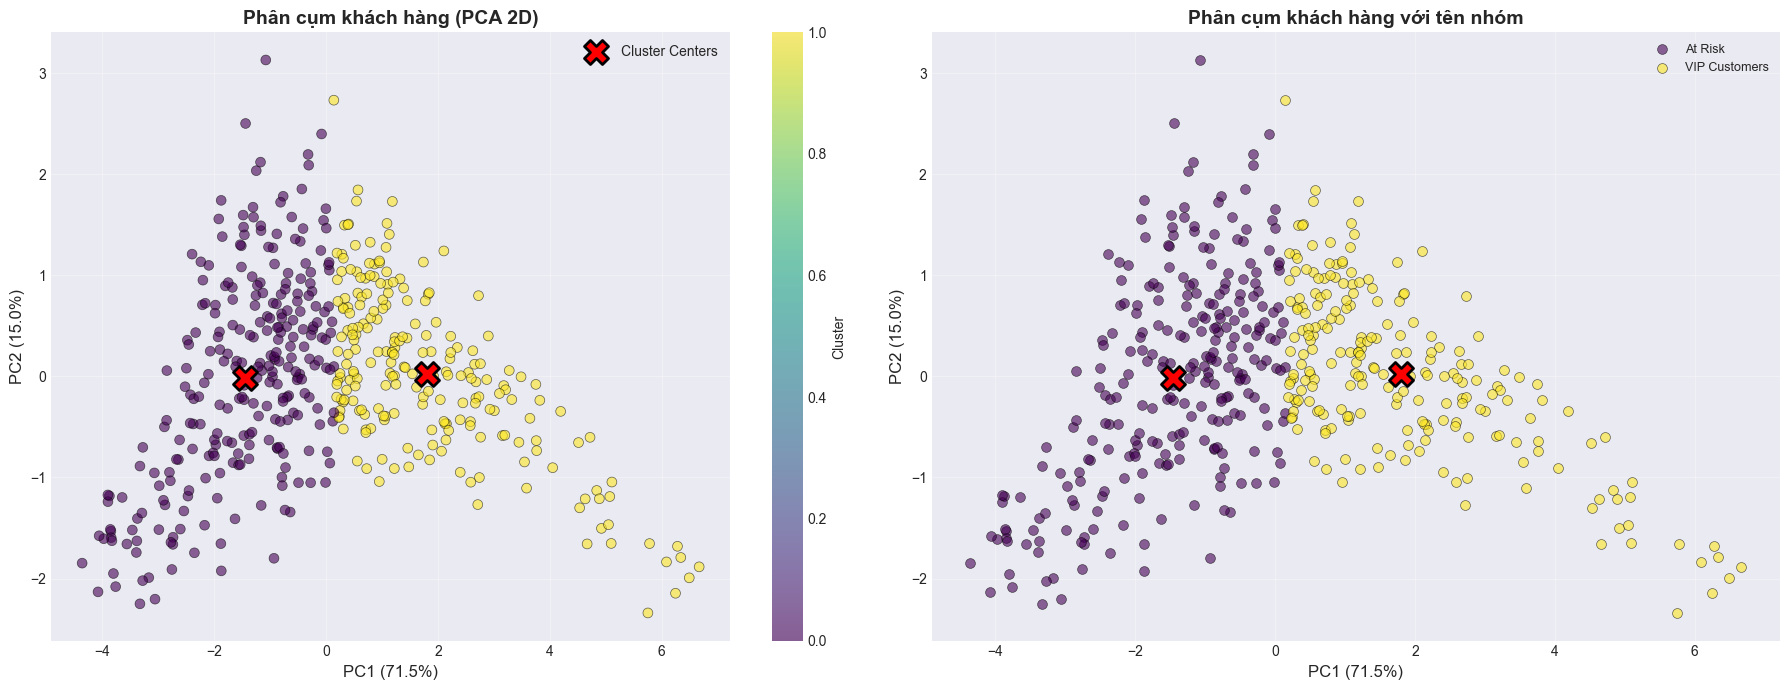

Đã lưu biểu đồ: '08_clustering_visualization_2d.png'


In [20]:
print("\nTRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM (PCA 2D & 3D)")

# Giảm chiều dữ liệu xuống 2D bằng PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"\nPhương sai giải thích bởi 2 PCA components:")
print(f"   PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")
print(f"   PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")
print(f"   Tổng: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 2D với cluster labels
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                          c=rfm['Cluster'], cmap='viridis', 
                          s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('Phân cụm khách hàng (PCA 2D)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Vẽ cluster centers
centers_2d = pca_2d.transform(kmeans_final.cluster_centers_)
axes[0].scatter(centers_2d[:, 0], centers_2d[:, 1], 
               c='red', marker='X', s=300, edgecolors='black', linewidth=2,
               label='Cluster Centers')
axes[0].legend()

# Colorbar
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2D với cluster names
colors = plt.cm.viridis(np.linspace(0, 1, best_k))
for i, cluster_name in cluster_names.items():
    cluster_data = X_pca_2d[rfm['Cluster'] == i]
    axes[1].scatter(cluster_data[:, 0], cluster_data[:, 1], 
                   c=[colors[i]], label=cluster_name, s=50, alpha=0.6, 
                   edgecolors='black', linewidth=0.5)

axes[1].scatter(centers_2d[:, 0], centers_2d[:, 1], 
               c='red', marker='X', s=300, edgecolors='black', linewidth=2)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[1].set_title('Phân cụm khách hàng với tên nhóm', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('08_clustering_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Đã lưu biểu đồ: '08_clustering_visualization_2d.png'")


In [21]:
print("\n" + "="*70)
print("PHÂN TÍCH CHI TIẾT TỪNG CLUSTER")
print("="*70)

for cluster_id in sorted(rfm['Cluster'].unique()):
    cluster_data = rfm[rfm['Cluster'] == cluster_id]
    cluster_name = cluster_names[cluster_id]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}: {cluster_name}")
    print(f"{'='*70}")
    print(f"Số lượng khách hàng: {len(cluster_data)} ({len(cluster_data)/len(rfm)*100:.2f}%)")
    
    print(f"\nThống kê chính:")
    print(f"   Recency (ngày):")
    print(f"      - Trung bình: {cluster_data['Recency'].mean():.1f}")
    print(f"      - Trung vị: {cluster_data['Recency'].median():.1f}")
    print(f"      - Min-Max: {cluster_data['Recency'].min():.0f} - {cluster_data['Recency'].max():.0f}")
    


PHÂN TÍCH CHI TIẾT TỪNG CLUSTER

CLUSTER 0: At Risk
Số lượng khách hàng: 267 (55.28%)

Thống kê chính:
   Recency (ngày):
      - Trung bình: 132.5
      - Trung vị: 108.0
      - Min-Max: 1 - 363

CLUSTER 1: VIP Customers
Số lượng khách hàng: 216 (44.72%)

Thống kê chính:
   Recency (ngày):
      - Trung bình: 37.3
      - Trung vị: 27.0
      - Min-Max: 1 - 233
